# Lectura de datos

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import numpy as np
from numpy import isnan
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt

#Así debería ser la manera correcta pero no se el por qué no funciona
#from google.colab import drive
#import os
#drive.mount('/content/gdrive')

#%cd '/content/gdrive/MyDrive'

# Autenticación con Google Drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Obtener el ID del archivo
file_name = 'Israel Palestina 1.csv'
file_list = drive.ListFile({'q': f"title = '{file_name}'"}).GetList()

# Verificar si se encontró el archivo
if len(file_list) > 0:
    file_id = file_list[0]['id']
    # Descargar el archivo
    downloaded = drive.CreateFile({'id': file_id})
    downloaded.GetContentFile(file_name)

    # Leer el archivo CSV
    df = pd.read_csv(file_name, encoding='latin1')
    print("Archivo leído exitosamente.")
else:
    print("Archivo no encontrado en Google Drive.")




Archivo leído exitosamente.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18090 entries, 0 to 18089
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   event_id_cnty       18090 non-null  object 
 1   event_date          18090 non-null  object 
 2   year                18090 non-null  int64  
 3   time_precision      18090 non-null  int64  
 4   disorder_type       18090 non-null  object 
 5   event_type          18090 non-null  object 
 6   sub_event_type      18090 non-null  object 
 7   actor1              18090 non-null  object 
 8   assoc_actor_1       2515 non-null   object 
 9   inter1              18090 non-null  int64  
 10  interaction         18090 non-null  int64  
 11  civilian_targeting  6458 non-null   object 
 12  iso                 18090 non-null  int64  
 13  region              18090 non-null  object 
 14  country             18090 non-null  object 
 15  admin1              18090 non-null  object 
 16  admi

In [ ]:
!pip install missingno

<Axes: >

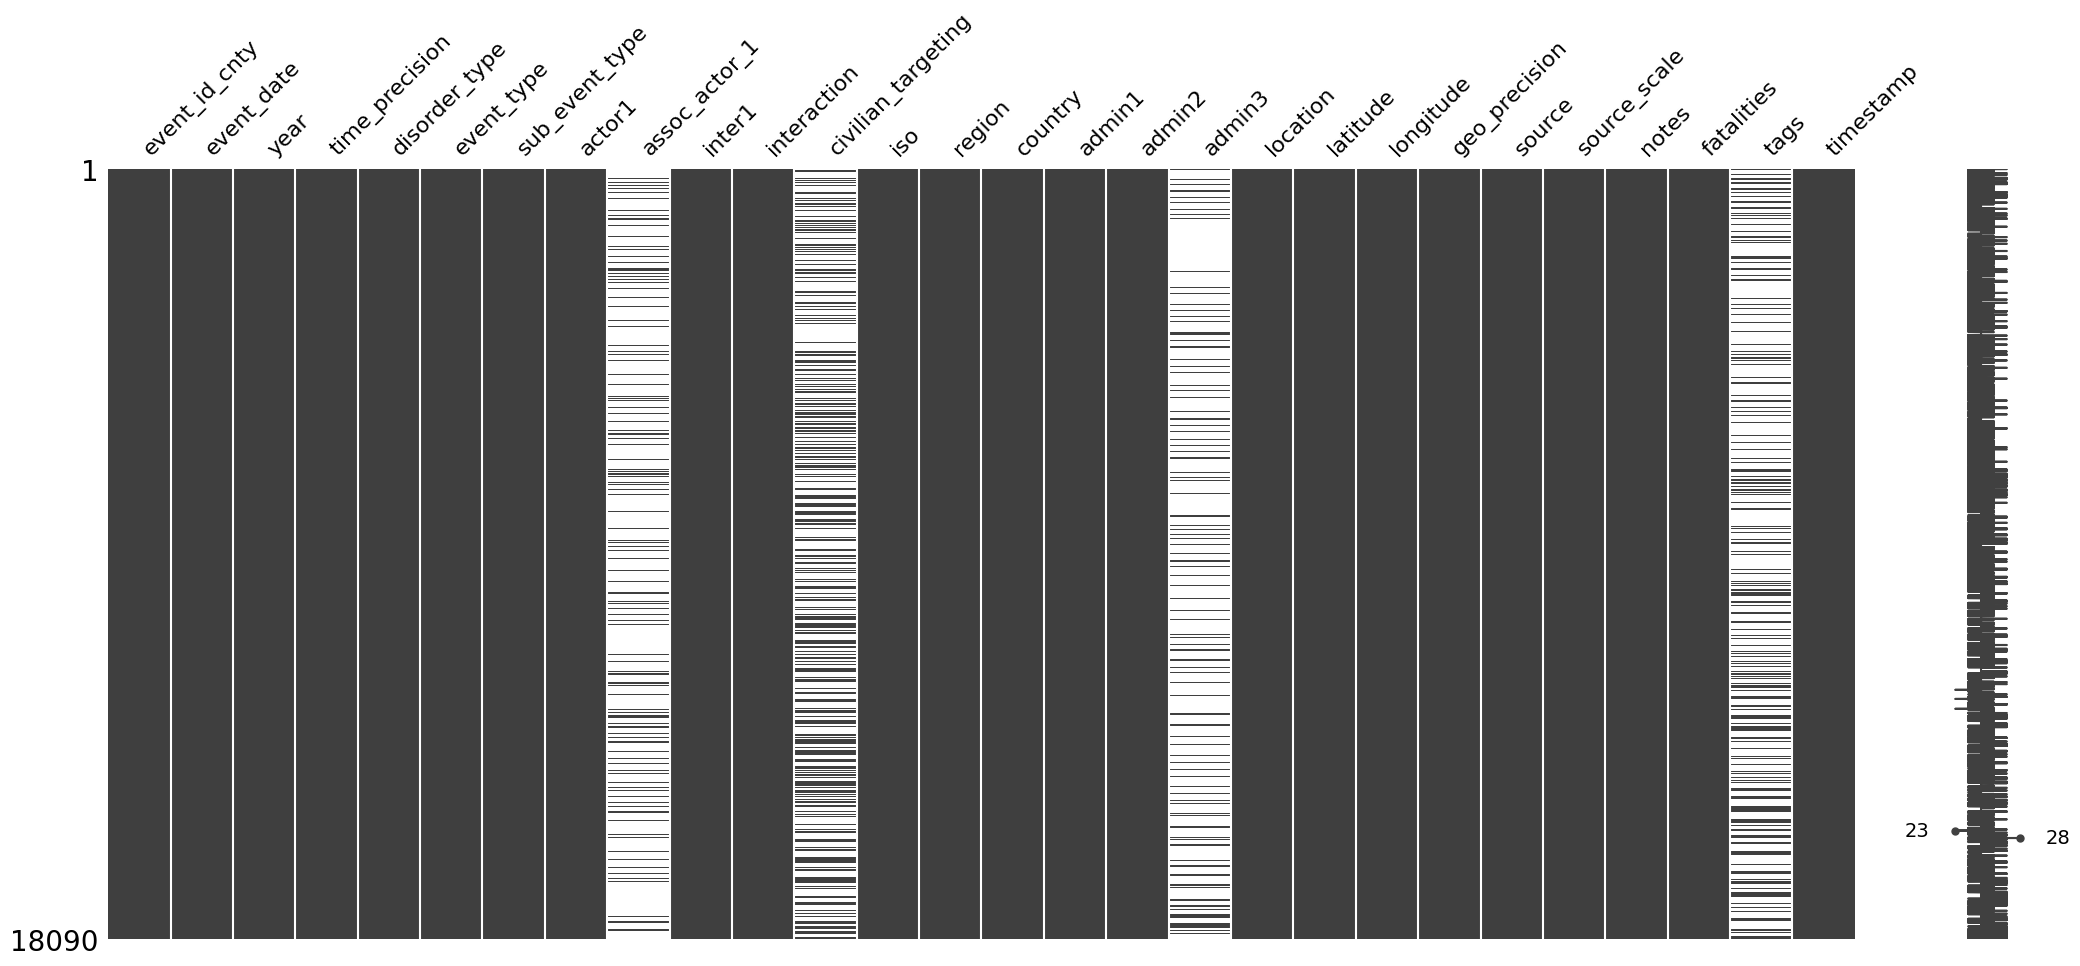

In [ ]:
import missingno as msno

%matplotlib inline
msno.matrix(df)

Estas columnas no la vamos a utilizar ya que no son de mi interés

In [ ]:
columnas_eliminar = ['assoc_actor_1', 'inter1', 'interaction', 'civilian_targeting',
                     'iso', 'tags', 'admin1', 'admin2', 'admin3']

df = df.drop(columns=columnas_eliminar)


In [ ]:
columnas_eliminar2 = ['event_id_cnty', 'time_precision', 'geo_precision', 'source',
                     'source_scale', 'notes', 'timestamp']
df = df.drop(columns=columnas_eliminar2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18090 entries, 0 to 18089
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   event_date      18090 non-null  object 
 1   year            18090 non-null  int64  
 2   disorder_type   18090 non-null  object 
 3   event_type      18090 non-null  object 
 4   sub_event_type  18090 non-null  object 
 5   actor1          18090 non-null  object 
 6   region          18090 non-null  object 
 7   country         18090 non-null  object 
 8   location        18090 non-null  object 
 9   latitude        18090 non-null  float64
 10  longitude       18090 non-null  float64
 11  fatalities      18090 non-null  int64  
dtypes: float64(2), int64(2), object(8)
memory usage: 1.7+ MB


Vamos a imputar los valores

In [ ]:
from sklearn.impute import SimpleImputer

# Crear el imputador con la estrategia de imputación por media
imputador = SimpleImputer(strategy='mean')

# Aplicar la imputación a las columnas numéricas
columnas_numericas = df.select_dtypes(include=['float64', 'int64']).columns
df[columnas_numericas] = imputador.fit_transform(df[columnas_numericas])


In [ ]:
#Hacemos una especie de Parseo de la columna event date y ordenamos las fechas de la más antigua a la más reciente
df['event_date'] = pd.to_datetime(df['event_date'])

df.sort_values(by='event_date',inplace=True)


In [ ]:

#Realizo una suma de decesos por día de cada país (para luegor graficar)
diario_df = df[['event_date','fatalities','country']].groupby(['event_date','country']).sum().reset_index()


In [ ]:
#Realizo un pivot para obtener decesos en columnas por país (para luego graficar)
diario_df_pivot = diario_df.pivot(index='event_date', columns='country', values='fatalities')



# **Decesos Diarios**

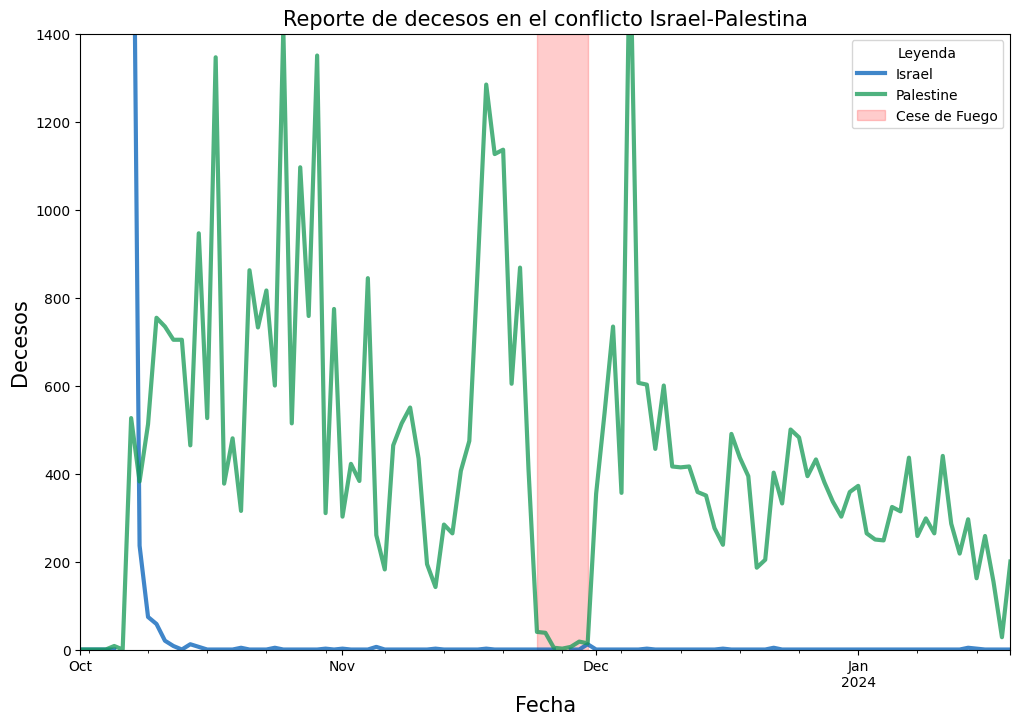

In [ ]:
#Graficación de la cantidad de decesos por cada facción y cese de fuego.

inicio_cese='2023-11-24'
fin_cese='2023-11-30'

fig,ax=plt.subplots(figsize=(12,8))

diario_df_pivot.plot(kind='line',color=['#005EB8','#149954'],ax=ax,alpha=0.75,lw=3)
ax.axvspan(inicio_cese,fin_cese,color='red',alpha=0.2,label='Cese de Fuego')

x_coord = diario_df_pivot.idxmax()['Israel']
y_coord = diario_df_pivot.max()['Israel']
label = '7 de Octubre'
plt.annotate(label, (x_coord, y_coord), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('Fecha', fontsize = 15)
plt.ylabel('Decesos', fontsize = 15)
plt.legend(title='Leyenda')
plt.ylim(0,1400)
plt.title('Reporte de decesos en el conflicto Israel-Palestina', fontsize = 15)
plt.savefig('Decesos')


# **Decesos acumulativos**

In [ ]:
#Sumo ventos diarios por pais
agrupados=df.groupby(['event_date','country']).sum().reset_index()

agrupados['decesos_acumulativos']= agrupados[['country','fatalities']].groupby(['country']).cumsum()

#Hago pivot (grafico luego)
agrupados_pivot = agrupados.pivot(index='event_date', columns='country', values='decesos_acumulativos')



In [ ]:
# Lleno datos vacios
# Determino rango
fecha_inicio = agrupados_pivot.index.min()
fecha_fin = agrupados_pivot.index.max()
rango = pd.date_range(start=fecha_inicio, end=fecha_fin, freq='D')

# Reindexar y completar los valores faltantes con el día anterior
pivot_df_acumulado = agrupados_pivot.reindex(rango).fillna(method='ffill')



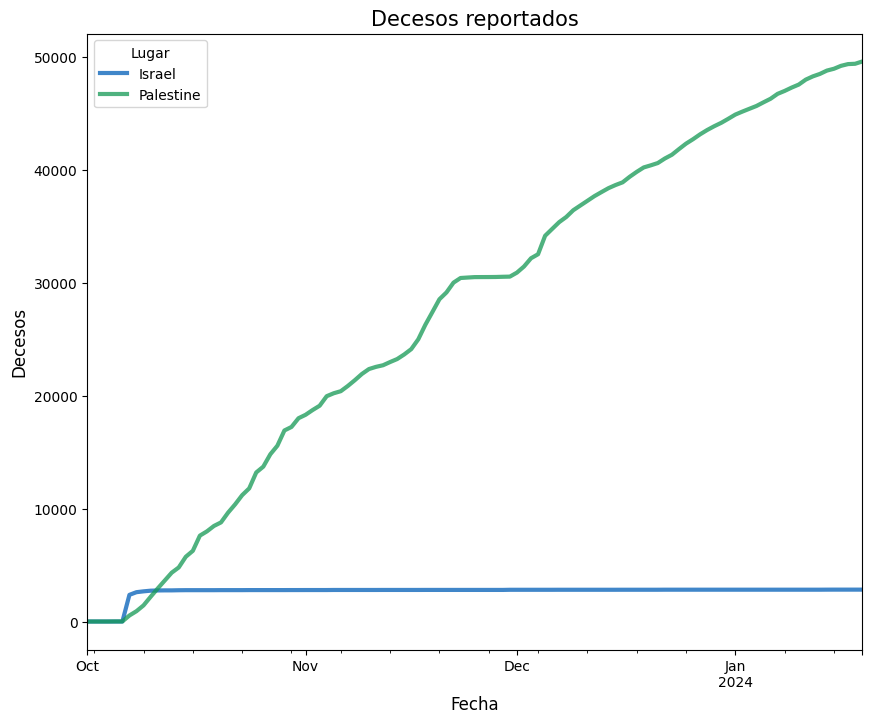

In [ ]:

fig, ax = plt.subplots(figsize = (10,8))
pivot_df_acumulado.plot(kind='line', color=['#005EB8','#149954'], alpha=0.75, lw = 3, ax=ax)
plt.legend(title='Lugar')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Decesos', fontsize=12)
plt.title('Decesos reportados', fontsize=15)
plt.savefig('Acumulados')

# **Tipos de Eventos**

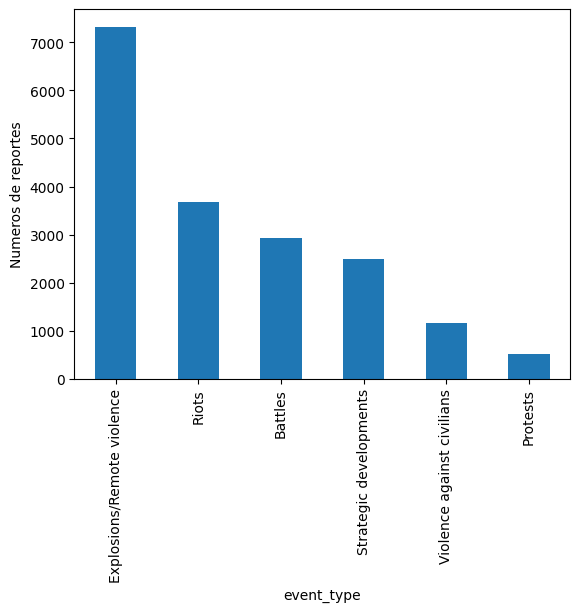

In [ ]:
df.event_type.value_counts().plot.bar()
plt.ylabel('Numeros de reportes')
plt.savefig('Reportes')

<Axes: xlabel='disorder_type'>

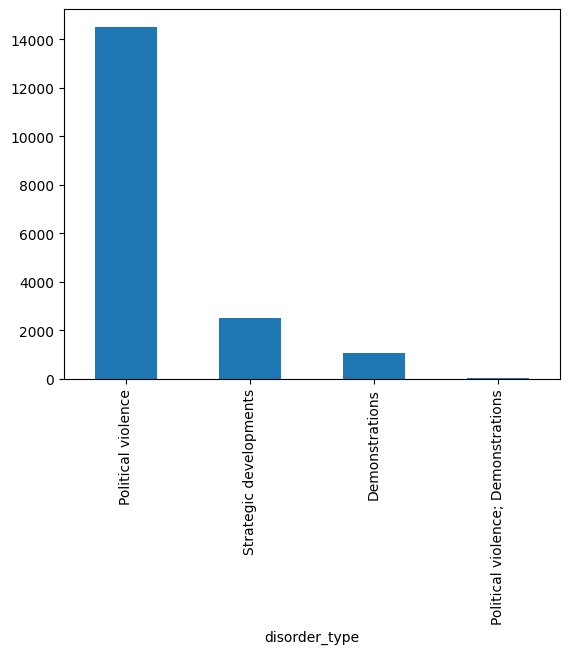

In [ ]:
df.disorder_type.value_counts().plot.bar()

# **Mapa de los sucesos**



Instalación de Folium

In [ ]:
pip install folium

In [ ]:
# Importación de folium para utilizarlo
import folium
from folium.plugins import HeatMap

In [ ]:
df.describe()

,event_date,year,latitude,longitude,fatalities
count,18090,18090.000000,18090.000000,18090.000000,18090.000000
mean,2023-11-20 17:19:31.343283712,2023.139359,31.781259,34.809868,2.897236
min,2023-10-01 00:00:00,2023.000000,29.500000,34.222600,0.000000
25%,2023-10-25 00:00:00,2023.000000,31.448600,34.435500,0.000000
50%,2023-11-16 00:00:00,2023.000000,31.554100,34.789400,0.000000
75%,2023-12-17 00:00:00,2023.000000,32.100000,35.201900,0.000000
max,2024-01-19 00:00:00,2024.000000,33.279200,35.677300,471.000000
std,NaN,0.346330,0.470346,0.408081,12.866310


In [ ]:
folium_hmap = folium.Map(location=[31.046051, 34.851612], zoom_start=10, titles="Conflicto")

In [ ]:
hm_wide = HeatMap(list(zip(df['latitude'], df['longitude'], df['fatalities'])))

In [ ]:
folium_hmap.add_child(hm_wide)

# *Regresión*

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

Prueba

In [ ]:
pivot_df_acumulado.sort_index(inplace=True)
pivot_df_acumulado

country,Israel,Palestine
2023-10-01,0.0,0.0
2023-10-02,0.0,0.0
2023-10-03,0.0,0.0
2023-10-04,0.0,0.0
2023-10-05,0.0,8.0
...,...,...
2024-01-15,2824.0,48947.0
2024-01-16,2824.0,49205.0
2024-01-17,2824.0,49359.0
2024-01-18,2824.0,49387.0


In [ ]:
# Skip to first deaths in the dataset
pivot_df_acumulado = pivot_df_acumulado[4:]

In [ ]:
pivot_df_acumulado.reset_index().index.values

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106])

In [ ]:
X = pivot_df_acumulado.reset_index().index.values.reshape(-1,1)
y = pivot_df_acumulado.reset_index()['Palestine']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Crear entidades polinómicas (grado 2)
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
# Ajustar un modelo de regresión polinómica
poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train)

# Predecir en el conjunto de prueba
y_pred = poly_reg.predict(X_test_poly)
# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Error cuadrático medio: {mse:.2f}")
print(f"R-cuadrado: {r2:.2f}")

Error cuadrático medio: 399665.64
R-cuadrado: 1.00


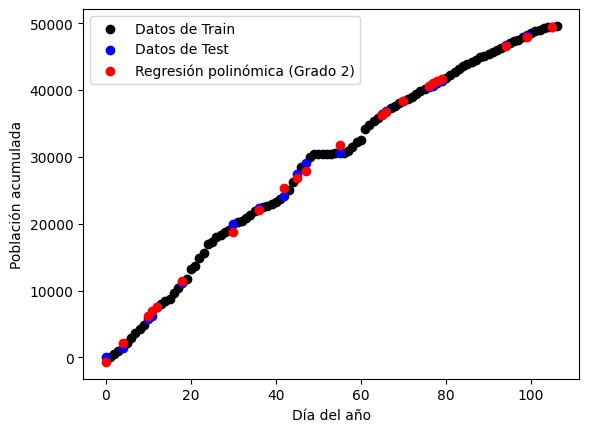

In [ ]:
# Ploteamos los datos originales y la línea de regresión polinómica
plt.scatter(X_train, y_train, color='black', label='Datos de Train')
plt.scatter(X_test, y_test, color='blue', label='Datos de Test')
plt.scatter(X_test, y_pred, color='red', label='Regresión polinómica (Grado 2)')
plt.xlabel('Día del año')
plt.ylabel('Población acumulada')
plt.legend()
plt.show()

In [ ]:
# Ampliar el índice para incluir los próximos 3 meses
ultima_fecha = pivot_df_acumulado.index.max()
proximo_3_meses = pd.date_range(start=ultima_fecha + pd.DateOffset(days=1), periods=90, freq='D')

# Último índice de datos anteriores
ultimo_indice = pivot_df_acumulado.reset_index().index.values[-1] - 20 # Where does this 20 come in?

# Crear valores de día del año correspondientes para los próximos 3 meses
futuro_3_meses = proximo_3_meses.to_series().dt.dayofyear.values.reshape(-1, 1) + ultimo_indice

# Use the polynomial regression model to make predictions for the next 3 months
predictions = poly_reg.predict(poly.transform(futuro_3_meses))


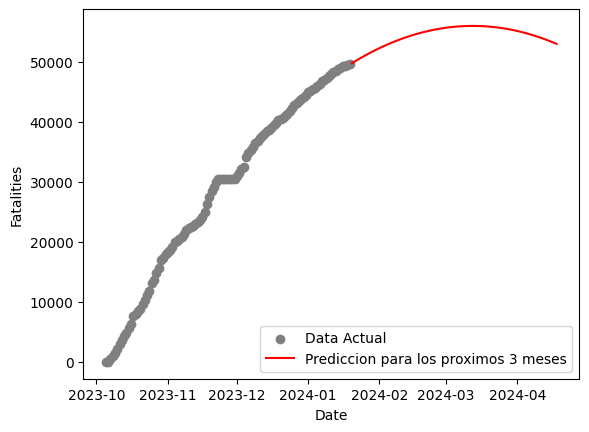

In [ ]:

# Ploteamos los datos originales, la línea de regresión polinómica y las predicciones para los próximos 3 meses.
plt.scatter(pivot_df_acumulado.index, y, color='grey', label='Data Actual')
plt.plot(proximo_3_meses, predictions, color='red', label='Prediccion para los proximos 3 meses')
plt.xlabel('Date')
plt.ylabel('Fatalities')
plt.legend()
plt.show()

In [ ]:
from scipy.optimize import curve_fit
import numpy as np

#Definimos el modelo logístico: Creamos una función llamada modelo_logistico que representa nuestro modelo logístico.
# Este modelo toma un conjunto de datos x como entrada y devuelve una estimación de y basada en tres parámetros: c, k y t0.
def modelo_logistico(x, c, k, t0):
    return c / (1 + np.exp(-k * (x - t0)))

#Definimos los datos x_data y y_data. x_data son los valores de x (en este caso, los índices de las fechas)
#ey y_data son los valores de y (en este caso, los números de fatalidades).

x_data = pivot_df_acumulado.reset_index().index.values
y_data = pivot_df_acumulado['Palestine']


#Definimos una estimación inicial para los parámetros del modelo.
# Estos valores iniciales son importantes para ayudar al algoritmo de optimización a converger a una solución.

inicio = [max(y_data), 1, np.median(x_data)]

# Utilizamos la función curve_fit para ajustar nuestro modelo a los datos.
# Esta función toma como entrada el modelo, los datos x y y, y una estimación inicial para los parámetros del modelo,
# y devuelve los parámetros óptimos que minimizan el error entre el modelo y los datos.
params, covariance = curve_fit(modelo_logistico, x_data, y_data, p0=inicio)

# Extraigo los parametros
c, k, t0 = params

# Generar una secuencia de valores x
x_model = np.linspace(x_data.min(), x_data.max(), 1000)

# Aplicar el modelo logístico
y_model = modelo_logistico(x_model, c, k, t0)


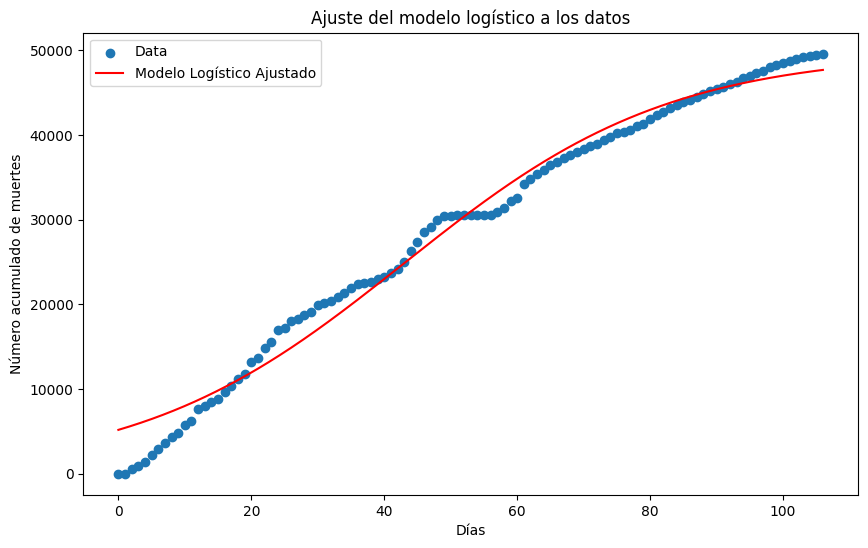

In [ ]:
# Plot the data and the model prediction
plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data, label='Data')
plt.plot(x_model, y_model, label='Modelo Logístico Ajustado', color='red')
plt.legend()
plt.xlabel('Días')
plt.ylabel('Número acumulado de muertes')
plt.title('Ajuste del modelo logístico a los datos')
plt.show()

Ajustes de HiperParámetros

In [ ]:
from sklearn.model_selection import GridSearchCV

# Definir el rango de valores de los hiperparámetros a explorar
param_grid = {
    'n_estimators': [100, 200, 300],  # Número de árboles en el bosque
    'max_depth': [None, 10, 20],       # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10]     # Número mínimo de muestras requeridas para dividir un nodo
}

# Crear una instancia del modelo Random Forest
rf_model = RandomForestRegressor(random_state=42)

# Realizar una búsqueda de hiperparámetros utilizando validación cruzada
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='neg_mean_squared_error')

# Ajustar el modelo a los datos de entrenamiento
grid_search.fit(X_train_poly, y_train)

# Obtener los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Obtener el mejor MSE obtenido
best_mse = -grid_search.best_score_
print("Best Mean Cross-Validation MSE:", best_mse)

Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Best Mean Cross-Validation MSE: 188382.47290536473
